In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import keras
from keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import utils
from tensorflow.keras import optimizers
from keras.constraints import max_norm
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score, roc_curve, roc_auc_score
from matplotlib import pyplot as plt
import random
%matplotlib inline

In [ ]:
df0 = pd.read_csv("Phenotypic_V1_0b.csv")
df0.fillna(0, inplace=True)
df0 = pd.get_dummies(df0)
df0 = df0.astype(float)
df0.head()

,SUB_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_SCORES,FIQ,VIQ,PIQ,ADI_R_SOCIAL_TOTAL_A,ADI_R_VERBAL_TOTAL_BV,ADI_RRB_TOTAL_C,ADI_R_ONSET_TOTAL_D,ADI_R_RSRCH_RELIABLE,ADOS_MODULE,ADOS_TOTAL,ADOS_COMM,ADOS_SOCIAL,ADOS_STEREO_BEHAV,ADOS_RSRCH_RELIABLE,ADOS_GOTHAM_SOCAFFECT,ADOS_GOTHAM_RRB,ADOS_GOTHAM_TOTAL,ADOS_GOTHAM_SEVERITY,SRS_VERSION,SRS_RAW_TOTAL,SRS_AWARENESS,SRS_COGNITION,SRS_COMMUNICATION,SRS_MOTIVATION,SRS_MANNERISMS,SCQ_TOTAL,AQ_TOTAL,OFF_STIMULANTS_AT_SCAN,VINELAND_RECEPTIVE_V_SCALED,VINELAND_EXPRESSIVE_V_SCALED,VINELAND_WRITTEN_V_SCALED,VINELAND_COMMUNICATION_STANDARD,VINELAND_PERSONAL_V_SCALED,VINELAND_DOMESTIC_V_SCALED,...,MEDICATION_NAME_Methylphanidate,MEDICATION_NAME_Methylphenidate Extended Release,MEDICATION_NAME_Methylphenidate Extended Release; Metadate,MEDICATION_NAME_Methylphenidate Extended Release; Methylphenidate,MEDICATION_NAME_Methylphenidate Extended Release; Methylphenidate,MEDICATION_NAME_Methylphenidate Extended Release; Sertraline,MEDICATION_NAME_Methylphenidate Extended Release; Sertraline; Mirtazapine,MEDICATION_NAME_Methylphenidate Transdermal;Guanfacine Extended Release; Citalopram,MEDICATION_NAME_Methylphenidate extended release,MEDICATION_NAME_Methylphenidate extended release; Risperidone,MEDICATION_NAME_Methylphenidate extended release; Risperidone; Methylphenidate; Guanfacine,MEDICATION_NAME_Methylphenidate transdermal patch,MEDICATION_NAME_Methylphenidate; Citalopram,MEDICATION_NAME_Methylphenidate; Guanfacine; Valproic Acid; Bupropion; dextroamphetamine and amphetamine,MEDICATION_NAME_Methylphenidate; Merthylphenidate Extended Release,MEDICATION_NAME_Methylphenidate; Methylphenidate Extended Release,MEDICATION_NAME_Methylphenidate; Methylphenidate Extended Release; Risperidone; Dextroamphetamine and Amphetamine,MEDICATION_NAME_Methylphenidate; Risperidone,MEDICATION_NAME_Mirtazapine,MEDICATION_NAME_Oxcarbazepine; Sertraline; Methylphenidate Extended Release; Bupropion,MEDICATION_NAME_Pantoprazole,MEDICATION_NAME_Paroxetine; Lisdexamfetamine,MEDICATION_NAME_Risperdone,MEDICATION_NAME_Risperidone,MEDICATION_NAME_Risperidone; Atomoxetine; Guanfacine,MEDICATION_NAME_Risperidone; Peroxatine; Methylphenidate Extended Release,MEDICATION_NAME_Risperidone; Quetiapine,MEDICATION_NAME_Risperidone; Sertraline,MEDICATION_NAME_Risperidone; Strattera; Methylphenidate,MEDICATION_NAME_Sertraline,MEDICATION_NAME_Sertraline; Guanfacine; Aripiprazole,MEDICATION_NAME_Sertraline; Guanfacine; altrex,MEDICATION_NAME_Sertraline; Risperidone,MEDICATION_NAME_Sertraline; Risperidone; Dextroamphetamine and Amphetamine,MEDICATION_NAME_Sertraline; Ziprasidone; Lisdexamfetamine,MEDICATION_NAME_Tenex;,MEDICATION_NAME_Valproic Acid,MEDICATION_NAME_Valproic acid; Lithium; Risperidone,MEDICATION_NAME_Ziprasidone,MEDICATION_NAME_Zolpidem; Lisinopril; Topiramato; Trazodone; Venlafaxine; Bupropion;
0,51456.0,1.0,4.0,55.4,1.0,0.0,126.0,118.0,128.0,-9999.0,-9999.0,-9999.0,-9999.0,0.0,4.0,9.0,2.0,7.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,51457.0,1.0,4.0,22.9,1.0,0.0,107.0,119.0,93.0,23.0,17.0,5.0,3.0,1.0,4.0,8.0,3.0,5.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,51458.0,1.0,1.0,39.2,1.0,0.0,93.0,80.0,108.0,13.0,18.0,7.0,4.0,1.0,4.0,20.0,6.0,14.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,51459.0,1.0,1.0,22.8,1.0,0.0,106.0,94.0,118.0,12.0,12.0,2.0,1.0,1.0,4.0,12.0,4.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,

In [ ]:
df1 = df0.copy()
for i in range(1,70):
    df1 = df1.append(df0)
    
print("After data augmentation: ")
df1.shape

After data augmentation: 


(77840, 292)

In [ ]:
df2 = df1.copy()
del df2['DX_GROUP']

mu, sigma = 0, 0.01
noise = np.random.normal(mu, sigma, [df2.shape[0], df2.shape[1]]) 
df3 = df2 + noise 

In [ ]:
df3['DX_GROUP'] = df1[['DX_GROUP']]

In [ ]:
sc = MinMaxScaler()
df3[df3.columns] = sc.fit_transform(df3[df3.columns]) 
x = df3.loc[:, df3.columns != 'DX_GROUP'].to_numpy()
y = df3.loc[:, df3.columns == 'DX_GROUP'].to_numpy()
print(type(x), type(y))
print(x)
print(y)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[[0.90591133 0.99999606 0.85049091 ... 0.04062563 0.04715137 0.0389145 ]
 [0.90651879 0.99999697 0.28554402 ... 0.02541311 0.03427632 0.0271949 ]
 [0.90715183 0.99969826 0.56894685 ... 0.04570574 0.03739664 0.04125706]
 ...
 [0.38877988 0.99989618 0.08028406 ... 0.03403453 0.04669706 0.03376133]
 [0.38941542 0.9998972  0.05278956 ... 0.03215644 0.03153868 0.04647485]
 [0.39004016 0.99989778 0.1385362  ... 0.03717578 0.03377416 0.03275317]]
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [ ]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(x, y, test_size=0.20,random_state=42) # changing test_size to 20

# Set data types for float features
X_Train = X_Train.astype('float32')
X_Test = X_Test.astype('float32')

# Set data types for categorical labels
Y_Train = keras.utils.to_categorical(Y_Train)
Y_Test = keras.utils.to_categorical(Y_Test)

print(X_Train.shape, Y_Train.shape, X_Test.shape, Y_Test.shape)

(62272, 291) (62272, 2) (15568, 291) (15568, 2)


In [ ]:
# Define a classifier network
h = 15 

model = Sequential()
model.add(Dense(h, input_dim=len(X_Train[1]), activation='relu', kernel_constraint=max_norm(1), kernel_initializer='glorot_normal'))
model.add(Dropout(0.3))
model.add(Dense(h, input_dim=h, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dropout(0.3))
model.add(Dense(h, input_dim=h, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dropout(0.3))
model.add(Dense(2, input_dim=h, activation='softmax', kernel_initializer='glorot_normal'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 15)                4380      
_________________________________________________________________
dropout (Dropout)            (None, 15)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                240       
_________________________________________________________________
dropout_1 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 15)                240       
_________________________________________________________________
dropout_2 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 3

In [ ]:
# Hyper-parameters for optimizer
learning_rate = 0.001
opt = optimizers.Adagrad(lr=learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) # no accuracy because y targets are continuous not binary

# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

# Train the model over 550 epochs using 10-observation batches and using the test holdout dataset for validation
num_epochs = 550
history = model.fit(X_Train, Y_Train, epochs=num_epochs, batch_size=10, validation_data=(X_Test, Y_Test), callbacks=[es])

Epoch 1/550
6228/6228 [==============================] - 10s 1ms/step - loss: 0.6925 - accuracy: 0.5461 - val_loss: 0.6618 - val_accuracy: 0.6666
Epoch 2/550
6228/6228 [==============================] - 9s 1ms/step - loss: 0.6627 - accuracy: 0.6092 - val_loss: 0.6342 - val_accuracy: 0.6846
Epoch 3/550
6228/6228 [==============================] - 9s 1ms/step - loss: 0.6406 - accuracy: 0.6397 - val_loss: 0.6074 - val_accuracy: 0.6955
Epoch 4/550
6228/6228 [==============================] - 9s 1ms/step - loss: 0.6194 - accuracy: 0.6694 - val_loss: 0.5810 - val_accuracy: 0.7313
Epoch 5/550
6228/6228 [==============================] - 9s 1ms/step - loss: 0.5995 - accuracy: 0.6876 - val_loss: 0.5609 - val_accuracy: 0.7403
Epoch 6/550
6228/6228 [==============================] - 9s 1ms/step - loss: 0.5855 - accuracy: 0.7016 - val_loss: 0.5398 - val_accuracy: 0.7729
Epoch 7/550
6228/6228 [==============================] - 9s 1ms/step - loss: 0.5702 - accuracy: 0.7171 - val_loss: 0.5244 - val_a

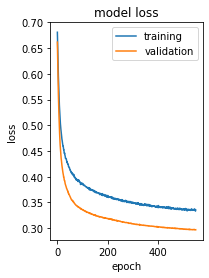

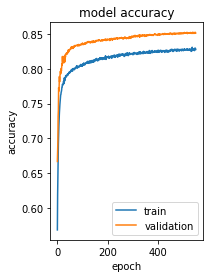

In [ ]:
epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.subplot(1, 2, 1)
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

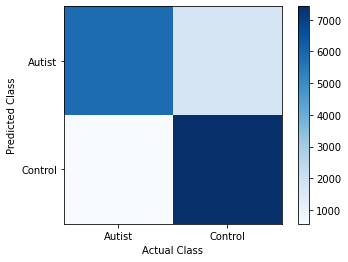

[[5838 1743]
 [ 566 7421]]
Accuracy: 0.8516829393627955
              precision    recall  f1-score   support

           0       0.91      0.77      0.83      7581
           1       0.81      0.93      0.87      7987

    accuracy                           0.85     15568
   macro avg       0.86      0.85      0.85     15568
weighted avg       0.86      0.85      0.85     15568



In [ ]:
# Tensorflow doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn

class_probabilities = model.predict(X_Test)
predictions = np.argmax(class_probabilities, axis=1)
true_labels = np.argmax(Y_Test, axis=1)

# Plot the confusion matrix
cm = confusion_matrix(true_labels, predictions)
#fig, ax = plt.subplots(figsize=(8,8))         
#sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues', ax=ax)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Autist', 'Control'])
plt.yticks(tick_marks, ['Autist', 'Control'])
plt.xlabel("Actual Class")
plt.ylabel("Predicted Class")
plt.show()
mcm = confusion_matrix(true_labels, predictions)
print(mcm)
print('Accuracy:', accuracy_score(true_labels, predictions))
print(classification_report(true_labels, predictions))

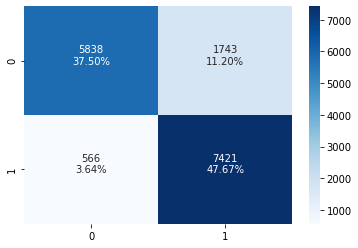

In [ ]:
import seaborn as sns 
group_counts = ["{0:0.0f}".format(value) for value in mcm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in mcm.flatten()/np.sum(mcm)]
labels = [f"{v1}\n{v2}\n" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(mcm, annot=labels, fmt='', cmap='Blues')

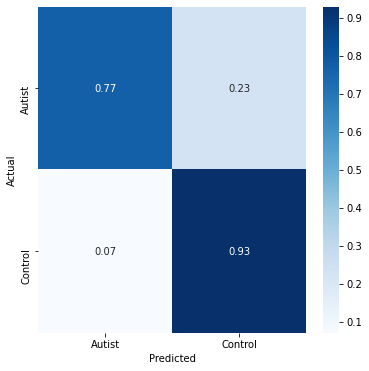

In [ ]:
mcm = mcm.astype('float') / mcm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,6))
target_names = ['Autist', 'Control']
sns.heatmap(mcm, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

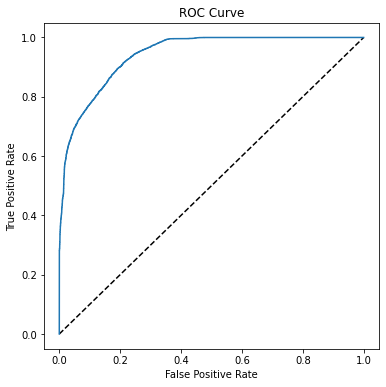

AUC: 0.9420440536806224


In [ ]:
y_scores = model.predict(X_Test)

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
auc = roc_auc_score(true_labels, y_scores[:,1])
print('AUC: ' + str(auc))